# After announcement, how many hours is XBI performing abnormally? Check against Historical XBI returns and IWM  index
### Hourly data not possible to obtain on yfinance, thus using daily data
# After announcement, how many days is XBI performing abnormally? Check against Historical XBI returns and IWM  index

[*********************100%***********************]  2 of 2 completed


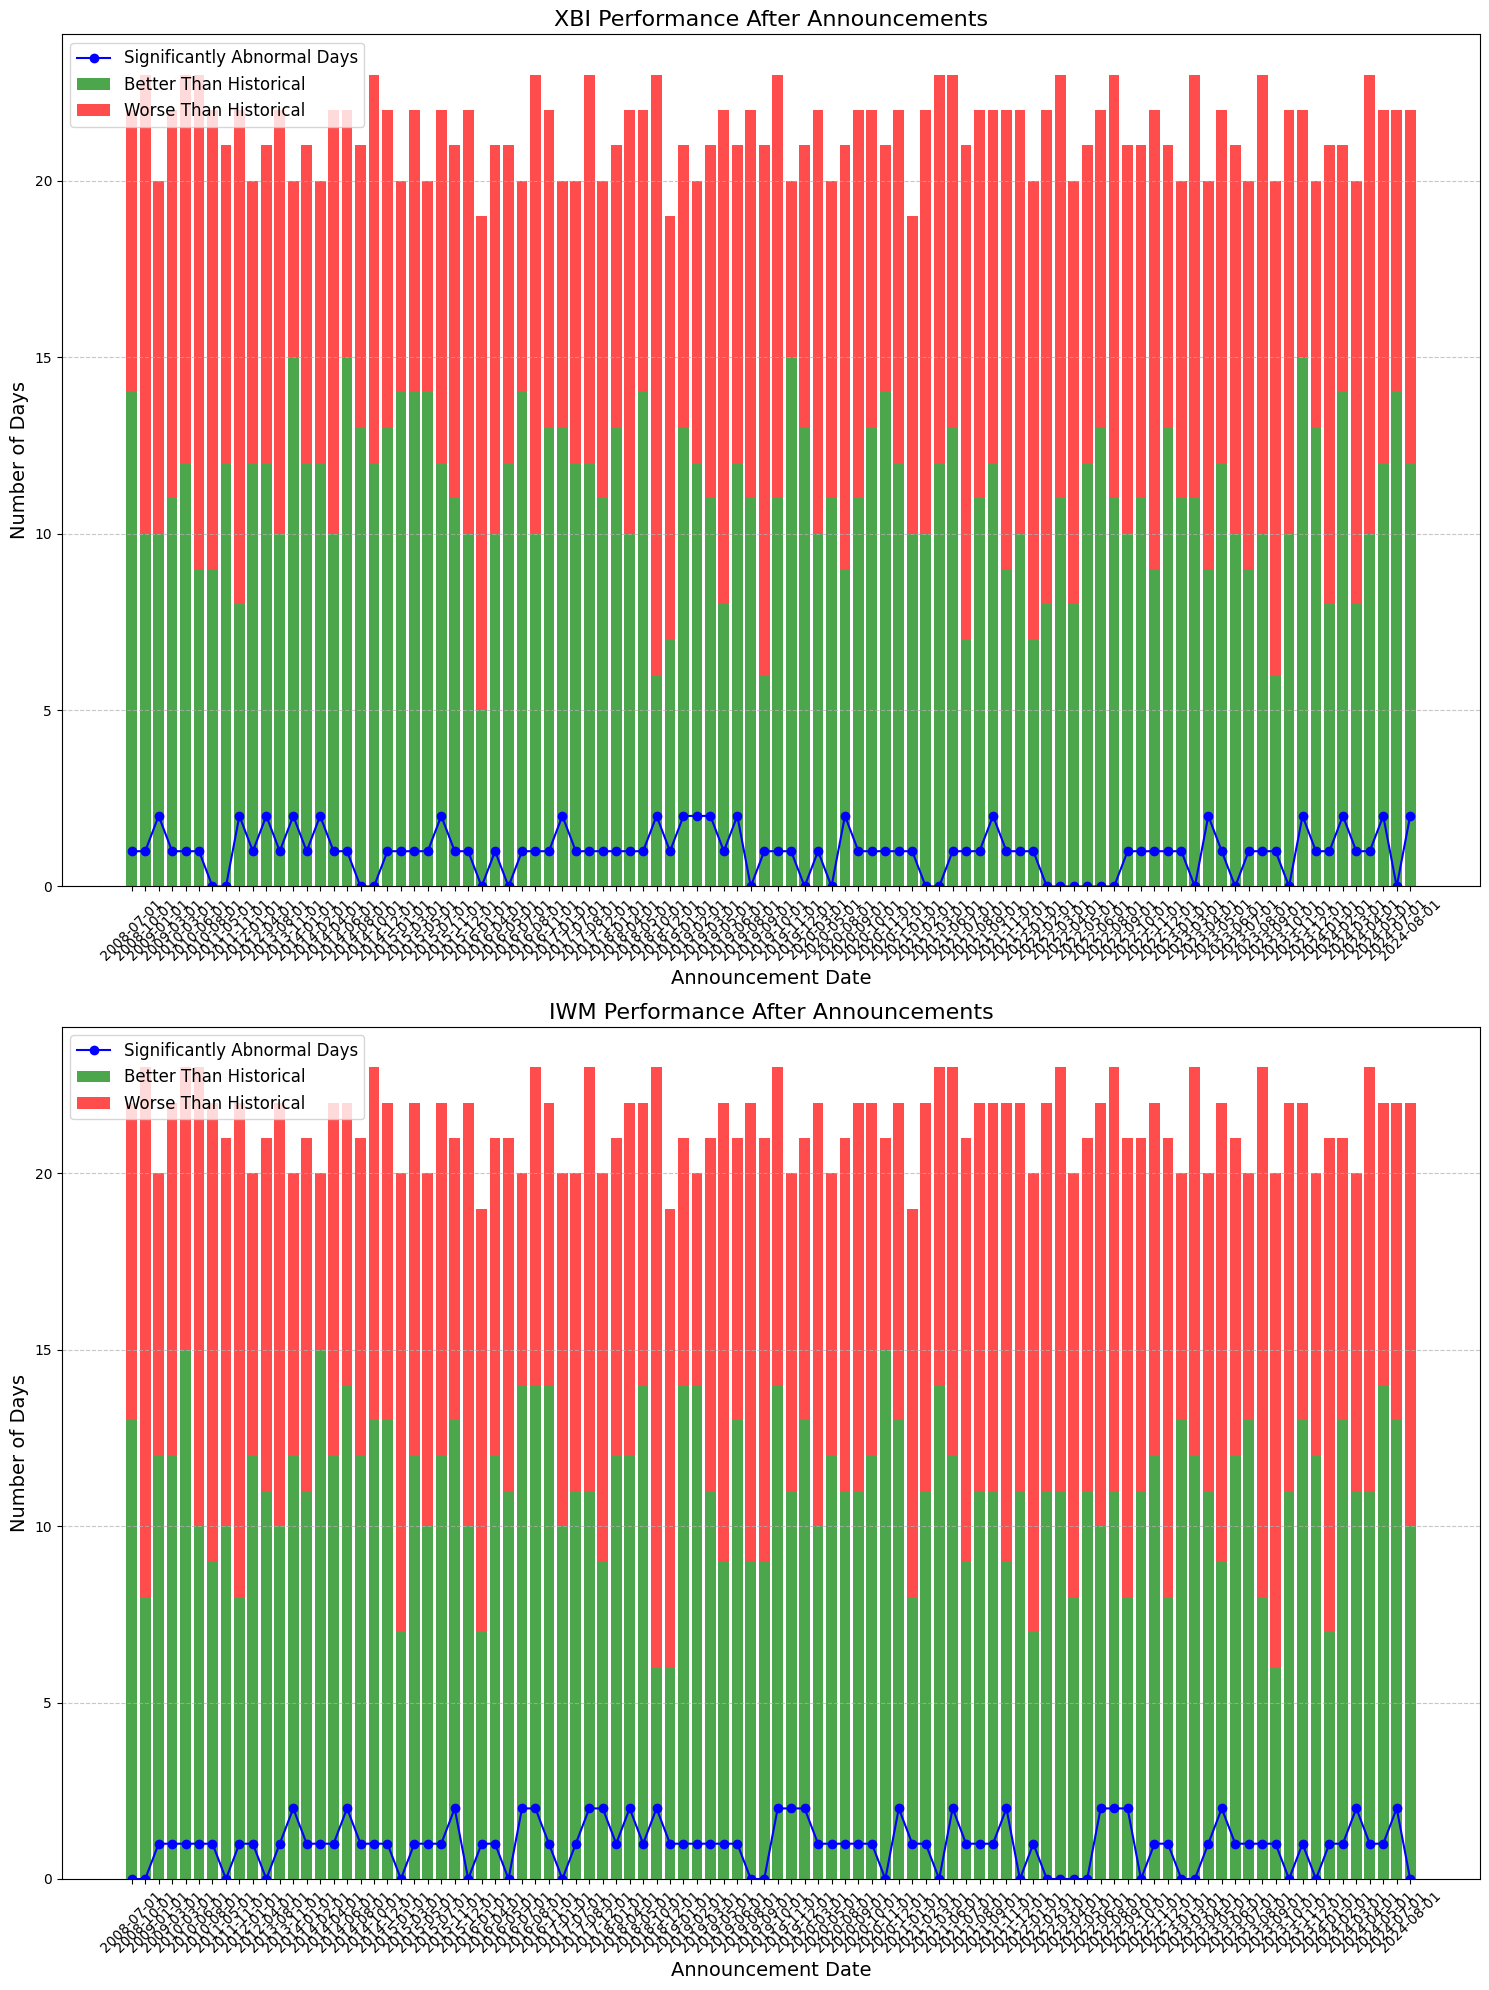


XBI Performance Summary:
Average Abnormal Days: 0.98
Average Better Days: 11.05
Average Worse Days: 10.33
Average Cumulative Abnormal Return: 38.40%

IWM Performance Summary:
Average Abnormal Days: 0.98
Average Better Days: 11.07
Average Worse Days: 10.31
Average Cumulative Abnormal Return: -21.38%

Comparison:
XBI outperformed IWM in 59 out of 96 announcements


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats

def load_ma_data(file_path):
    df_ma = pd.read_csv(file_path)
    df_ma['Date Announced'] = pd.to_datetime(df_ma['Date Announced'], format='%b-%y').dt.tz_localize('UTC')
    return df_ma

def download_historical_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date, interval='1d')['Adj Close']
    if data.index.tz is None:
        data.index = data.index.tz_localize('UTC')
    return data

def calculate_returns(data):
    return data.pct_change().dropna()

def analyze_performance(returns, ticker, announcement_dates, window=30):
    """The code is trying to assess the impact of specific announcements on a company's stock performance.

1. **Evaluate Stock Performance**: It looks at how the stock price of a particular company (identified by its ticker symbol) behaves around important announcement dates, like earnings reports or product launches.

2. **Measure Abnormal Returns**: It calculates "abnormal returns," which indicate whether the stock's performance during the days following an announcement is better or worse than what would typically be expected based on past performance.

3. **Identify Significant Days**: It identifies days where the stock's returns are significantly different from average returns, which could suggest a strong market reaction to the announcement.

4. **Summarize Impact**: It summarizes key statistics for each announcement date, including:
   - How many days had significant abnormal returns.
   - How many days the stock performed better or worse than average.
   - Overall average and total abnormal returns for the period after the announcement.

Overall, the function helps investors or analysts understand the effects of specific announcements on stock performance, potentially guiding investment decisions."""
    results = []
    ticker_mean = returns[ticker].mean()
    ticker_std = returns[ticker].std()

    for announcement_date in announcement_dates:
        event_start = announcement_date
        event_end = announcement_date + pd.Timedelta(days=window)
        event_returns = returns.loc[event_start:event_end, ticker]

        if event_returns.empty:
            continue

        abnormal_returns = (event_returns - ticker_mean) / ticker_std
        z_scores = stats.zscore(event_returns)
        significant_days = np.abs(z_scores) > 1.96  # 95% confidence interval

        results.append({
            'Announcement Date': announcement_date,
            'Abnormal Days': significant_days.sum(),
            'Better Days': (abnormal_returns > 0).sum(),
            'Worse Days': (abnormal_returns < 0).sum(),
            'Average Abnormal Return': abnormal_returns.mean(),
            'Cumulative Abnormal Return': abnormal_returns.sum(),
            'Max Abnormal Return': abnormal_returns.max(),
            'Min Abnormal Return': abnormal_returns.min(),
        })

    return pd.DataFrame(results)

def visualize_results(xbi_results, iwm_results):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    
    dates = xbi_results['Announcement Date'].dt.strftime('%Y-%m-%d')
    
    # XBI Plot
    ax1.bar(dates, xbi_results['Better Days'], color='green', label='Better Than Historical', alpha=0.7)
    ax1.bar(dates, xbi_results['Worse Days'], bottom=xbi_results['Better Days'], color='red', label='Worse Than Historical', alpha=0.7)
    ax1.plot(dates, xbi_results['Abnormal Days'], color='blue', marker='o', label='Significantly Abnormal Days')

    ax1.set_title('XBI Performance After Announcements', fontsize=16)
    ax1.set_xlabel('Announcement Date', fontsize=14)
    ax1.set_ylabel('Number of Days', fontsize=14)
    ax1.legend(loc='upper left', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # IWM Plot
    ax2.bar(dates, iwm_results['Better Days'], color='green', label='Better Than Historical', alpha=0.7)
    ax2.bar(dates, iwm_results['Worse Days'], bottom=iwm_results['Better Days'], color='red', label='Worse Than Historical', alpha=0.7)
    ax2.plot(dates, iwm_results['Abnormal Days'], color='blue', marker='o', label='Significantly Abnormal Days')

    ax2.set_title('IWM Performance After Announcements', fontsize=16)
    ax2.set_xlabel('Announcement Date', fontsize=14)
    ax2.set_ylabel('Number of Days', fontsize=14)
    ax2.legend(loc='upper left', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def main():
    df_ma = load_ma_data("XBI_Deals_CSV.csv")
    tickers = ['XBI', 'IWM']
    start_date = '2007-01-01'
    end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

    historical_data = download_historical_data(tickers, start_date, end_date)
    returns = calculate_returns(historical_data)

    xbi_results = analyze_performance(returns, 'XBI', df_ma['Date Announced'].unique())
    iwm_results = analyze_performance(returns, 'IWM', df_ma['Date Announced'].unique())

    visualize_results(xbi_results, iwm_results)

    print("\nXBI Performance Summary:")
    print(f"Average Abnormal Days: {xbi_results['Abnormal Days'].mean():.2f}")
    print(f"Average Better Days: {xbi_results['Better Days'].mean():.2f}")
    print(f"Average Worse Days: {xbi_results['Worse Days'].mean():.2f}")
    print(f"Average Cumulative Abnormal Return: {xbi_results['Cumulative Abnormal Return'].mean():.2%}")

    print("\nIWM Performance Summary:")
    print(f"Average Abnormal Days: {iwm_results['Abnormal Days'].mean():.2f}")
    print(f"Average Better Days: {iwm_results['Better Days'].mean():.2f}")
    print(f"Average Worse Days: {iwm_results['Worse Days'].mean():.2f}")
    print(f"Average Cumulative Abnormal Return: {iwm_results['Cumulative Abnormal Return'].mean():.2%}")

    print("\nComparison:")
    print(f"XBI outperformed IWM in {(xbi_results['Cumulative Abnormal Return'] > iwm_results['Cumulative Abnormal Return']).sum()} out of {len(xbi_results)} announcements")

if __name__ == "__main__":
    main()


### Analysis of Trading Strategy Based on Announcement Dates

#### Understanding the Results:

1. **XBI's Performance**:
   - After announcements, XBI typically had about **1 day** where its performance was significantly different from what was expected.
   - It did **better than usual for about 11 days** and **worse for about 10 days**.
   - Overall, XBI delivered a strong return, achieving **38.4%** more than expected after these announcements.

2. **IWM's Performance**:
   - IWM also averaged about **1 day** of significant abnormal performance.
   - Similar to XBI, it had **11 better days** and **10 worse days**.
   - However, IWM’s overall return was disappointing, at **-21.4%**, indicating it fell short of expectations.

3. **Comparison**:
   - XBI outperformed IWM in **59 out of 96 announcements** (around **61%** of the time).

#### Implications for Your Trading Strategy:

1. **Timing Your Trades**:
   - Focus on the **first 21 days** after an announcement, where you can expect both better and worse performance days.
   - Be ready for increased price fluctuations, especially right after announcements.

2. **Choosing Between XBI and IWM**:
   - XBI is likely the better investment choice, given its consistent outperformance compared to IWM.
   - The positive return trend for XBI indicates good potential for profit, while IWM shows higher risk due to its negative performance.

3. **Entry Point**:
   - Consider buying XBI **just before or immediately after** an announcement, as its historical data suggests it often rises afterward.

4. **Exit Strategy**:
   - Plan to hold your investment for about **3 weeks** (or 21 trading days) to take advantage of both better and worse performance days.
   - Setting a **stop-loss order** can help protect against significant losses, especially given the volatility.

5. **Risk Management**:
   - Even though XBI shows a positive trend, the nearly equal number of better and worse days signals that volatility is high.

6. **Monitoring Performance**:
   - Pay close attention to XBI’s price movements in the first few days after announcements.
   - If it starts underperforming relative to historical patterns, consider exiting your position early.

7. **Short-Term Focus**:
   - This strategy is better suited for **short-term trading** rather than long-term investing.
   - The high volatility and limited period of abnormal returns (around 21 days) suggest that quick trading may be necessary.

8. **Continuous Evaluation**:
   - Regularly assess your strategy as market conditions evolve.
   - Remember that past performance doesn’t guarantee future results, so stay updated on factors that could influence XBI’s response to announcements.